In [1]:
%load_ext memory_profiler

In [3]:
#import necessary packages
import numpy as np
import sys
import math
import pickle
import re
import isoprene_rates as rate
from math import exp as EXP
from copy import deepcopy
import matplotlib.pyplot as plt
import time
import csv
import pandas as pd
import random
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import dijkstra
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse.csgraph import csgraph_from_dense
from scipy.sparse import lil_matrix
from scipy.sparse.csgraph import connected_components

In [1]:
# Import the AMORE algorithm

In [3]:
import AMORE_v2 as am

# Camphene

In [5]:
# Camphene Rate Functions

In [7]:
def arrhenius(A,n,Ea,T):
    rate = A*(T**n)*math.exp(-Ea/T)
    return rate

def ISOM(a1,a2,a3,f1,f2,f3,f4,f5, temp, m):
    ar = arrhenius(a1,a2,a3,temp)
    iso = f1*(temp**4) + f2*(temp**3) + f3*(temp**2) + f4*temp + f5
    
    return iso*ar

def extra(a1,a2,a3,f1,temp,m):
    ar = arrhenius(a1,a2,a3, temp)
    return ar
def falloff(a1,a2,a3,f1,f2,f3,f4,f5,f6,f7,temp,m):
    e1 = f1*((temp/300)**f2)*math.exp(-f3/temp)*m
    r1 = e1/(a1*((temp/300)**a2))*math.exp(-a3/temp)
    fr1 = 1/(1+((math.log10(r1))**2))
    if f5 == 0 or f6 == 0:
        lnrate = math.log(e1/(1+r1)) + fr1*math.log(f4)
    else:
        fr2 = (1-f4)*math.exp(-temp/f5) + f4*math.exp(-temp/f6) + math.exp(-f7/temp)
        if f7== 0:
            fr2 = fr2 -1
        lnrate = math.log(e1/(1+r1)) + fr1*math.log(fr2)
    return math.exp(lnrate)
def get_rates(rate_numbers, rate_type,a_list_2,b_list_3,temp,press,M,sza):
    rates = []
    for i in range(len(rate_numbers)):
        if rate_type[i] == 'WALL':
            rates.append(0)
        elif rate_type[i] == 'HV':
            ind = a_list_2.index(rate_numbers[i][1][0])
            ind2 = b_list_3[ind].index(sza)
            r = b_list_3[ind][ind2+1]*rate_numbers[i][1][1]
            rates.append(r)
        elif rate_type[i] == 'FALLOFF':
            rates.append(falloff(rate_numbers[i][0][0],rate_numbers[i][0][1],rate_numbers[i][0][2],rate_numbers[i][1][0],rate_numbers[i][1][1],rate_numbers[i][1][2],rate_numbers[i][1][3],rate_numbers[i][1][4],rate_numbers[i][1][5],rate_numbers[i][1][6],temp,M))
        elif rate_type[i] == 'NORMAL':
            r = arrhenius(rate_numbers[i][0],rate_numbers[i][1],rate_numbers[i][2],temp)
            rates.append(r)
        elif rate_type[i]=='ISOM':
            r = ISOM(rate_numbers[i][0][0], rate_numbers[i][0][1],rate_numbers[i][0][2], rate_numbers[i][1][0], rate_numbers[i][1][1], rate_numbers[i][1][2], rate_numbers[i][1][3], rate_numbers[i][1][4],temp,M)
            rates.append(r)
        elif rate_type[i]=='EXTRA':
            r = extra(rate_numbers[i][0][0], rate_numbers[i][0][1],rate_numbers[i][0][2], rate_numbers[i][1][0],temp,M)
            rates.append(r)
        else:
            rates.append(0)
    return rates
CFACTOR = 2.5e+19;
RO2 = 0.01*10e-9;
SUN = 0.5;
TEMP = 295;
M = am.pressure_to_m(1000,295);
sza = 0;

In [9]:
# old files
folder = 'C:/Users/woods/OneDrive/Documents/Python/Code/camphene_6g_with_spinup/'
dict_str = 'C:/Users/woods/OneDrive/Documents/Python/Code/camphene_6gen_mech_dictionary.dict'
mech_str = 'C:/Users/woods/OneDrive/Documents/Python/Code/Camphene_6gen_mechanism.txt'

In [11]:
vol_str = 'C:/Users/woods/OneDrive/Documents/Python/Code/camphene_6g_with_spinup/camphene_6g.psim'

In [13]:
fileObject = open(vol_str, "r")
vol = fileObject.read()
vol_raw = vol.split('\n')[5:-2]


In [15]:
vol_dic = {}
for i in vol_raw:
    vol_dic[i.split('   ')[0]] = float(i.split('   ')[1])
    

In [17]:
vols = []
for i in vol_dic:
    vols.append(np.log10(vol_dic[i]))
plt.hist(vols)
plt.xlabel("Saturation Vapor Pressure (log$_{10}$ atm)")
plt.ylabel("Species Count")
plt.savefig('vapor_pressure.png')

NameError: name 'np' is not defined

In [ ]:
henry_str = 'C:/Users/woods/OneDrive/Documents/Python/Code/camphene_6g_with_spinup/camphene_6g.henry'

In [ ]:
fileObject = open(henry_str, "r")
henry = fileObject.read()
henry_raw = henry.split('\n')[:-2]


In [ ]:
mech_str_m = 'C:/Users/woods/OneDrive/Documents/Python/Code/AMORE_v2_paper_files/GECKO Mech copy/camphene_200_12_9_conc_filter/camphene200.mech'
fileObject = open(mech_str_m, "r")
m_raw = fileObject.read()
mech_m_raw = m_raw.split('\n')[:-2]

In [ ]:
mech_m_raw = mech_m_raw[4:-1]

In [21]:
r_lsit = set()
for i in mech_m_raw:
    r_lsit.add(i.split('=>')[0])

NameError: name 'mech_m_raw' is not defined

In [26]:
henry_dic = {}
for i in henry_raw:
    henry_dic[i.split('  ')[3].split(' ')[0]] = float(i.split('  ')[1])
    

In [27]:
henry_dat = []
vol_dat = []
species_for_cat = []
for i in vol_dic:
    if i in henry_dic:
        henry_dat.append(np.log10(henry_dic[i]))
        vol_dat.append(np.log10(vol_dic[i]))
        species_for_cat.append(i)

In [28]:
for i in vol_dic:
    if i not in henry_dic:
        print('yes')

Text(0, 0.5, 'Vol')

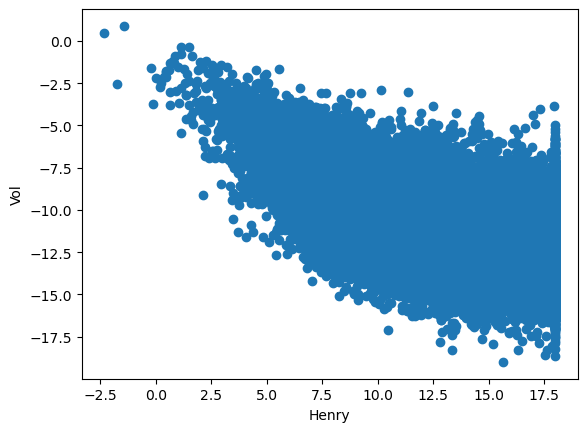

In [29]:
plt.scatter(henry_dat, vol_dat)
plt.xlabel("Henry")
plt.ylabel("Vol")

In [30]:
from sklearn.cluster import KMeans

In [31]:
data = []
for i in range(len(henry_dat)):
    data.append([henry_dat[i], vol_dat[i]])

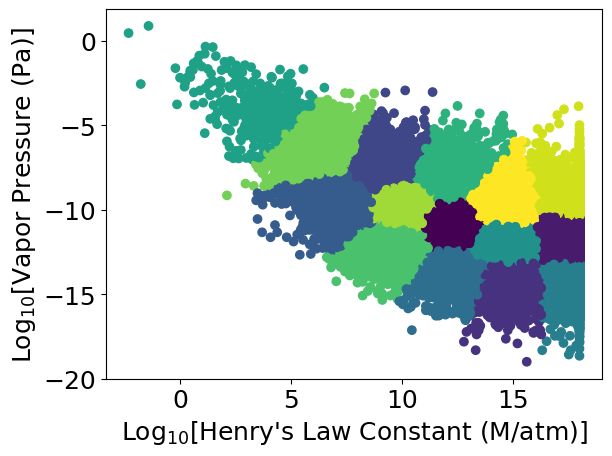

In [33]:


plt.rcParams['font.size'] = 18
kmeans = KMeans(n_clusters=15)
kmeans.fit(data)

plt.scatter(henry_dat, vol_dat, c=kmeans.labels_)
plt.yticks([0,-5,-10,-15,-20]) 
plt.xticks([0,5,10,15]) 

#plt.scatter(np.log10(1800000000), np.log10(7.345e-08), color='red')
#plt.scatter(np.log10(16000000000.0), np.log10(5.905e-12), color='red')
plt.ylabel('Log$_{10}$[Vapor Pressure (Pa)]')
plt.xlabel("Log$_{10}$[Henry's Law Constant (M/atm)]")
plt.savefig('henrys_law.png', dpi=300, bbox_inches='tight')

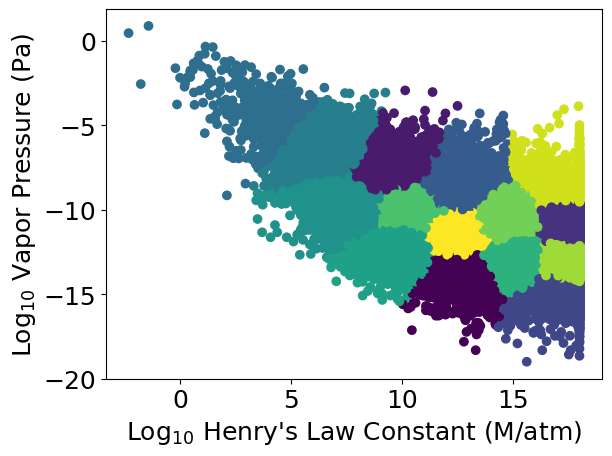

In [45]:


plt.rcParams['font.size'] = 18
kmeans = KMeans(n_clusters=15)
kmeans.fit(data)

plt.scatter(henry_dat, vol_dat, c=kmeans.labels_)
plt.yticks([0,-5,-10,-15,-20]) 
plt.xticks([0,5,10,15]) 


#plt.scatter(np.log10(1800000000), np.log10(7.345e-08), color='red')
#plt.scatter(np.log10(16000000000.0), np.log10(5.905e-12), color='red')
plt.ylabel('Log$_{10}$ Vapor Pressure (Pa)')
plt.xlabel("Log$_{10}$ Henry's Law Constant (M/atm)")
plt.savefig('henrys_law.png', dpi=100, bbox_inches='tight')

In [47]:
clusters = kmeans.cluster_centers_

In [61]:
center_specs = []
for j in range(len(clusters)):
    dists = []
    for i in range(len(henry_dat)):
        dists.append(np.sqrt((henry_dat[i]-clusters[j][0])**2 + (vol_dat[i]-clusters[j][1])**2))
    
    center_specs.append(species_for_cat[dists.index(min(dists))])

In [64]:
cat_dict = {i:[] for i in range(15)}
for i in range(len(kmeans.labels_)):
    cat_dict[kmeans.labels_[i]].append(species_for_cat[i][1:])

In [67]:
import pickle

with open('cat_dict_50_new.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(cat_dict, f, pickle.HIGHEST_PROTOCOL)

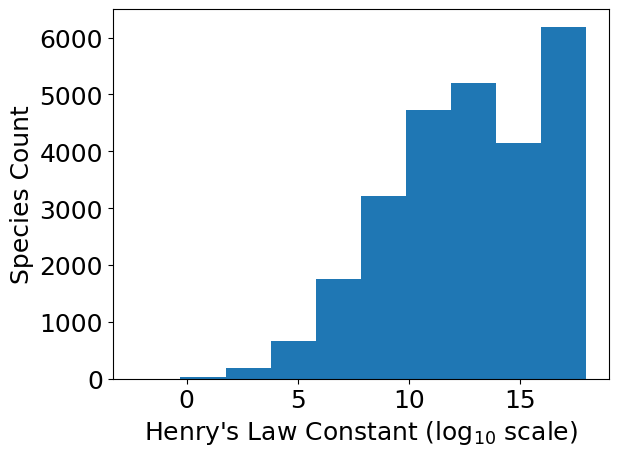

In [69]:
henrys = []
for i in henry_dic:
    henrys.append(np.log10(henry_dic[i]))
plt.hist(henrys)
plt.xlabel("Henry's Law Constant (log$_{10}$ scale)")
plt.ylabel("Species Count")
plt.savefig('henrys_law.png')

In [70]:
#preamble
folder = 'C:/Users/woods/OneDrive/Documents/Python/Code/propane/'
dict_str = 'C:/Users/woods/OneDrive/Documents/Python/Code/camphene_6g_with_spinup/camphene_6g.dict'
mech_str = 'C:/Users/woods/OneDrive/Documents/Python/Code/camphene_6g_with_spinup/camphene_6g.mech'
fileObject = open(dict_str, "r")
dict_spec = fileObject.read()
fileObject = open(mech_str, "r")
mech = fileObject.read()
species_list_raw = dict_spec.split('\n')
species_list_names = [i.split(' ')[0] for i in species_list_raw]
#mech_str = 'C:/Users/woods/OneDrive/Documents/Python/Code/Camphene_6gen_mechanism.txt'
fileObject = open(dict_str, "r")
dict_spec = fileObject.read()
fileObject = open(mech_str, "r")
mech = fileObject.read()
mech_list_raw = mech.rsplit('\n')[4:]
mech_list_raw.remove('')
for i in range(len(mech_list_raw)):
    if mech_list_raw[i][0] != 'G' and mech_list_raw[i][0] != 'A' and mech_list_raw[i][0] != 'W':
        mech_list_raw[i-1] = mech_list_raw[i-1] + mech_list_raw[i]
        mech_list_raw[i] = ''
mech_list_raw_2 = []
for i in mech_list_raw:
    if i != '':
        mech_list_raw_2.append(i)
# separating reactants, products and rates
reacs_raw = []
prods_raw = []
rates_raw = []
count = 0
#photo table
fileObject = open(folder + "O3_300DU.phot","r")
photo_table = fileObject.read()
for i in mech_list_raw_2:
    if 'E-' in i and 'E+' in i:
        ll1 = i.split('E-',1)
        ll2 = i.split('E+',1)
        if len(ll1[0])>len(ll2[0]):
            ll = ll2
            mark = 'E+'
        else:
            ll = ll1
            mark = 'E-'
        reac_prod = ll[0][:-5]
        rates = ll[0][-5:] + mark + ll[1]
        rp = reac_prod.split('=>')
        reacs_raw.append(rp[0])
        if len(rp)>1:
            prods_raw.append(rp[1])
        else:
            prods_raw.append('')
        rates_raw.append(rates)
    elif 'E-' in i:
        ll = i.split('E-',1)
        reac_prod = ll[0][:-5]
        rates = ll[0][-5:] + 'E-' + ll[1]
        rp = reac_prod.split('=>')
        reacs_raw.append(rp[0])
        if len(rp)>1:
            prods_raw.append(rp[1])
        else:
            prods_raw.append('')
        rates_raw.append(rates)
    elif 'E+' in i:
        ll = i.split('E+',1)
        reac_prod = ll[0][:-5]
        rates = ll[0][-5:] + 'E+' + ll[1]
        rp = reac_prod.split('=>')
        reacs_raw.append(rp[0])
        if len(rp)>1:
            prods_raw.append(rp[1])
        else:
            prods_raw.append('')
        rates_raw.append(rates)
    count = count + 1
if 'END' in rates_raw[-1]:
    print(rates_raw[-1])
    rates_raw[-1] = rates_raw[-1][:-3]
    print(rates_raw[-1])
# separating reactants, products and rates
rates_raw_2 = []
rxn_raw = []
for i in mech_list_raw_2:
    if 'E-' in i and 'E+' in i:
        ll1 = i.split('E-',1)
        ll2 = i.split('E+',1)
        if len(ll1[0])>len(ll2[0]):
            ll = ll2
            mark = 'E+'
        else:
            ll = ll1
            mark = 'E-'
        reac_prod = ll[0][:-5]
        rates = ll[0][-5:] + mark + ll[1]
    elif 'E-' in i:
        ll = i.split('E-',1)
        reac_prod = ll[0][:-5]
        rates = ll[0][-5:] + 'E-' + ll[1]

    elif 'E+' in i:
        ll = i.split('E+',1)
        reac_prod = ll[0][:-5]
        rates = ll[0][-5:] + 'E+' + ll[1]
    rates_raw_2.append(rates)
    rxn_raw.append(reac_prod)
reac_list = []
prod_list = []
reac_coeff_list = []
prod_coeff_list = []
reac_list = []
for i in reacs_raw:
    rx = []
    i2 = i.replace('(+M)','')
    ll = i2.split('+')
    for j in ll:
        rec = j.split(' ')
        for k in rec:
            if len(k)>0:
                rx.append(k)
    
    reac_list.append(rx)
for i in prods_raw:
    px = []
    nx = []
    i2 = i.replace('(+M)','+ M')
    ll = i2.split('+')
    for j in ll:
        pro = j.split(' ')
        kl = []
        for k in pro:
            if len(k)>0:
                kl.append(k)
        if len(kl)==2:
            nx.append(float(kl[0]))
            #print(nx)
            px.append(kl[1])
        elif len(kl)==1:
            nx.append(1)
            px.append(kl[0])
    prod_list.append(px)
    prod_coeff_list.append(nx)
rates_split = []
for i in rates_raw:
    x = i.split(' ')
    y = []
    for j in x:
        if j != '' and j != '/':
            y.append(j)
    rates_split.append(y)
photo_raw = photo_table.split('/')
photo_raw2 = []
for i in photo_raw:
    if ' 10' in i:
        photo_raw2.append(i)
a_list = []
b_list = []
for i in range(len(photo_raw2)):
    split1 = photo_raw2[i].split(' 10\n')
    a = split1[0].split(' ')
    for k in range(len(a)):
        if a[-k] != ' ' and a[-k] != '':
            a_list.append(a[-k])
            break
    b = split1[1]
    b_list.append(b)
a_list = a_list[1:]
a_list_2 = []
for i in a_list:
    a_list_2.append(float(i))
b_list = b_list[1:]
b_list_2 = [i.split('\n')[:-1] for i in b_list]
b_list_3 = []
b_list_2[-1].remove('END ')
for i in b_list_2:
    ll = []
    for j in i:
        nn = j.split('  ')
        for k in nn:
            if k!='':
                ll.append(float(k))
    b_list_3.append(ll)
rate_type = []
rate_numbers = []
for i in rates_raw:
    if 'FALLOFF' in i:
        rate_type.append('FALLOFF')
        parts = i.split('FALLOFF')
        part0 = parts[0].split(' ')
        nums0 = []
        for k in part0:
            if k != '' and k != ' ' and k!= '/':
                k = k.replace('/','')
                nums0.append(float(k))
        part1 = parts[1].split(' ')
        nums1 = []
        for k in part1:
            if k != '' and k != ' ' and k!= '/':
                k = k.replace('/','')
                nums1.append(float(k))
        rate_numbers.append([nums0,nums1])
    elif 'EXTRA' in i:
        rate_type.append('EXTRA')
        parts = i.split('EXTRA')
        part0 = parts[0].split(' ')
        nums0 = []
        for k in part0:
            if k != '' and k != ' ' and k!= '/':
                k = k.replace('/','')
                nums0.append(float(k))
        part1 = parts[1].split(' ')
        nums1 = []
        for k in part1:
            if k != '' and k != ' ' and k!= '/':
                k = k.replace('/','')
                nums1.append(float(k))
        rate_numbers.append([nums0,nums1])
    elif 'ISOM' in i:
        rate_type.append('ISOM')
        parts = i.split('ISOM')
        part0 = parts[0].split(' ')
        nums0 = []
        for k in part0:
            if k != '' and k != ' ' and k!= '/':
                k = k.replace('/','')
                nums0.append(float(k))
        part1 = parts[1].split(' ')
        nums1 = []
        for k in part1:
            if k != '' and k != ' ' and k!= '/':
                k = k.replace('/','')
                nums1.append(float(k))
        rate_numbers.append([nums0,nums1])
    elif 'LOW' in i:
        rate_type.append('LOW')
        parts = i.split('LOW')
        part0 = parts[0].split(' ')
        nums0 = []
        for k in part0:
            if k != '' and k != ' ' and k!= '/':
                k = k.replace('/','')
                nums0.append(float(k))
        part1 = parts[1].split(' ')
        nums1 = []
        for k in part1:
            if k != '' and k != ' ' and k!= '/':
                k = k.replace('/','')
                nums1.append(float(k))
        rate_numbers.append([nums0,nums1])
    elif 'HV' in i:
        rate_type.append('HV')
        parts = i.split('HV')
        part0 = parts[0].split(' ')
        nums0 = []
        for k in part0:
            if k != '' and k != ' ' and k!= '/':
                k = k.replace('/','')
                nums0.append(float(k))
        part1 = parts[1].split(' ')
        nums1 = []
        for k in part1:
            if k != '' and k != ' ' and k!= '/':
                k = k.replace('/','')
                nums1.append(float(k))
        rate_numbers.append([nums0,nums1])
    elif 'WIN' in i:
        rate_type.append('WALL')
        rate_numbers.append([0])
        #print(i.split('WIN'))
        
    elif 'WOU' in i:
        rate_type.append('WALL')
        #print(i.split('WOU'))
        rate_numbers.append([0])
    else:
        rate_type.append('NORMAL')
        nums = i.split(' ')
        nums_real = []
        for k in nums:
            if k != ' ' and k!= '':
                nums_real.append(float(k))
        rate_numbers.append(nums_real)
k_list = get_rates(rate_numbers, rate_type,a_list_2,b_list_3,298,1000,M,0)


1.000E+00  0.0      0.END
1.000E+00  0.0      0.


In [72]:
i = 0
while 'GCMPHEN' not in reac_list[i]:
    i = i+1
background_rxns = list(range(i))

aero_rxns = []
for i in range(len(reac_list)):
    if 'AOU' in reac_list[i] or 'AIN' in reac_list[i]:
        aero_rxns.append(i)

In [73]:
#species list
species_list_names.extend(['PERO1','PERO2','PERO3','PERO4','PERO5','PERO6','PERO7','PERO8',
                    'PERO9','MEPERO','OXYGEN','HV','NOTHING','M','EXTRA', 'ISOM', 'TBODY','FALLOFF'])
species_list_names = list(set(species_list_names))
species_list = list(range(len(species_list_names)))
spec_len = len(species_list)

In [74]:
reac_len = len(reac_list)

In [75]:
dic = {species_list_names[i]:i for i in range(spec_len)}

In [76]:
reac_coeff_list = []
for i in reac_list:
    rl = []
    for j in i:
        rl.append(1)
    reac_coeff_list.append(rl)

In [77]:
#reac_list
reac_list_n = deepcopy(reac_list)
prod_list_n = deepcopy(prod_list)
for i in range(len(reac_list_n)):
    for j in range(len(reac_list_n[i])):
        if reac_list_n[i][j][0]=='G':
            reac_list_n[i][j] = reac_list_n[i][j][1:]
for i in range(len(prod_list_n)):
    for j in range(len(prod_list_n[i])):
        if prod_list_n[i][j][0]=='G':
            prod_list_n[i][j] = prod_list_n[i][j][1:]
for i in range(len(reac_list_n)):
    if 'M' in reac_list_n[i]:
        reac_list_n[i].remove('M')

In [78]:
#background_spc
#a list of background species to be excluded from our reaction network for visual clarity (and also because they will mess with the drg reduction method)
background_spc_0 = ['TBODY','AIN','AOU','ISOM','HO','OH','NO','NO2','NO3','HO2','O3','CH3OO','PERO1','PERO2','PERO3','PERO4','PERO5','PERO6','PERO7','PERO8',
                    'PERO9','MEPERO','OXYGEN','HV','H', 'MALAHY', 'FURON', 'CH3O2', 'H2','NOTHING','M','EXTRA','CO2','CO','O2','N2O5','H2O','H2O2','H2Od','SO2',
                  'H2S','HF','H2S','N2H4','HN3','HI','HBr',
                  'HCl','HCN','H2Se','H2Te','NH2OH','HBrO','HClO','H3PO2','HPO3',
                  'H2O3','OF2','O2F2','NOHSO4','COS','N2F4','N2O4','N2O3','HNO3',
                  'HNO2','N2O','NF5','NI3','H2SO4','CS2','H2CO3','H2SO3','SO2Cl2','S4N4','H2SO5',
                  'H2S2O7','S2F10','H3NO3S','Br2S','SF6','SF4', 'CH3CO3']
background_spc = []
background_spc_n = []
for i in background_spc_0:
    if i in species_list_names:
        background_spc_n.append(i)
        background_spc.append(species_list_names.index(i))

In [79]:
remove_these = set([species_list_names.index('HV'), species_list_names.index('NOTHING'),species_list_names.index('M'),species_list_names.index('EXTRA')])


In [80]:
# remove redundant species
for i in range(len(reac_list)):
    if any([x in remove_these for x in reac_list[i]]):
        
        for j in range(len(reac_list[i])):
            if reac_list[i][j] not in remove_these:
                rx = [reac_list[i][j]]
        reac_list[i] = rx

In [81]:
#background_rxns
background_conc = [0.0002,
                   
 0.015,
 0.5,
 0.001,
 0.007,
 20,
 0.0001,
 0.0001,
 0.0001,
 0.0001,
 0.0001,
 0.0001,
 0.0001,
 0.0001,
 0.0001,
 0.0001,
  210000000,
 4.0727831285287275e-29,
 1e-5,
 1e-5,
 1e-5,
 1e-5,
 1e-5,
 4.0727831285287275e-29,
 4.0727831285287275e-29,
 4.0727831285287275e-29,
 400,
 9,
 210000000,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [82]:
# atmospheric inputs
atm_cond = {}
temp = 298
pressure = 1000
solar_zenith = 0
solar_factor = 1
atm_cond['temp'] = temp
atm_cond['pres'] = pressure
atm_cond['sza'] = solar_zenith
atm_cond['sun'] = solar_factor

In [83]:
#background concentrations
background_dict = {}
for i in range(len(background_spc_n)):
    if i<len(background_conc):
        background_dict[background_spc_n[i]] = background_conc[i]
    else:
        background_dict[background_spc_n[i]] = 0

In [84]:
#reactions
rxn_dict = {}
rxn_dict['reac'] = reac_list_n
rxn_dict['reac_coeff'] = reac_coeff_list
rxn_dict['prod'] = prod_list_n
rxn_dict['prod_coeff'] = prod_coeff_list
rxn_dict['k'] = k_list

In [85]:
# algorithm settings
settings = {}
settings['root'] = 'TT0000'
settings['# of species desired'] = 200

In [86]:
scnd_reactants = {}

In [87]:
inputs = {'spc':species_list_names, 'rxn':rxn_dict, 'bck':background_dict, 'scnd':scnd_reactants, 'atm cond':atm_cond,'settings':settings}

In [88]:
#second reactants
second_reactants = []
for i in inputs['rxn']['reac']:
    if len(i)==2:
        second_reactants.append(i[1])
second_reactants = list(set(second_reactants))
second_reactants_2 = []
for i in second_reactants:
    if i not in inputs['bck']:
        second_reactants_2.append(i)
second_reactants = deepcopy(second_reactants_2)
prnt_str = 'Please provide concentrations for the following species: '
for i in second_reactants:
    prnt_str = prnt_str + i + ' '
print(prnt_str)

Please provide concentrations for the following species: AOU AIN MODO2 A02000 FALLOFF XH3O2 YO HCOOH 


In [89]:
scnd_reactants = {}

In [90]:
del mech

### Camphene Inputs

In [112]:
settings = {}

In [114]:
settings['roots'] = ['CMPHEN']
settings['Weak rxn cutoff'] = 0.000001
settings['Remove weak reactions'] = True
settings['Mechanism Size'] = 75
settings['Background Rxns'] = background_rxns
settings['Aerosol Rxns'] = aero_rxns

In [116]:
settings['Weak rxn cutoff'] = 0.000000
settings['Remove weak reactions'] = True
settings['Categories'] = []
settings['Protected'] = ['CMPHEN']

In [118]:
dic = {species_list_names[i]:i for i in range(spec_len)}

In [120]:
k_lists = [get_rates(rate_numbers, rate_type,a_list_2,b_list_3,295,1000,M,0),
           get_rates(rate_numbers, rate_type,a_list_2,b_list_3,295,1000,M,0),
           get_rates(rate_numbers, rate_type,a_list_2,b_list_3,295,1000,M,0),
           get_rates(rate_numbers, rate_type,a_list_2,b_list_3,295,1000,M,0),
           get_rates(rate_numbers, rate_type,a_list_2,b_list_3,270,1000,M,86),
           get_rates(rate_numbers, rate_type,a_list_2,b_list_3,270,1000,M,86)]

In [123]:
reaction_list = []
for i in range(len(reac_list_n)):
    r = reac_list_n[i]
    p = {}
    for j in range(len(prod_list_n[i])):
        p[prod_list_n[i][j]] = prod_coeff_list[i][j]
    k1 = 'null'
    k2 = [k_lists[0][i], k_lists[1][i], k_lists[2][i], k_lists[3][i], k_lists[4][i], k_lists[5][i]]
    k3 = 1
    k4 = rates_raw[i]
    reaction_list.append(am.Reaction(r,p,k1,k2,k3,k4))

In [125]:
camphene_mech = am.Mechanism(species_list_names, reaction_list)

In [127]:
settings['Categories'] = [['cat'+str(i),cat_dict[i]] for i in cat_dict]

In [129]:
two_set = set()
for i in camphene_mech.reactions:
    if len(i.reactants)==2:
        two_set.add(i.reactants[1])

In [131]:
no_counts = {'AIN','AOU','EXTRA','FALLOFF','FALOFF','HV','ISOM','TBODY'}

In [135]:
def arrhenius(A,n,Ea,T):
    rate = A*(T**n)*math.exp(-Ea/T)
    return rate
def falloff(a1,a2,a3,f1,f2,f3,f4,f5,f6,f7,temp,m):
    e1 = f1*((temp/300)**f2)*math.exp(-f3/temp)*m
    r1 = e1/(a1*((temp/300)**a2))*math.exp(-a3/temp)
    fr1 = 1/(1+((math.log10(r1))**2))
    if f5 == 0 or f6 == 0:
        lnrate = math.log(e1/(1+r1)) + fr1*math.log(f4)
    else:
        fr2 = (1-f4)*math.exp(-temp/f5) + f4*math.exp(-temp/f6) + math.exp(-f7/temp)
        if f7== 0:
            fr2 = fr2 -1
        lnrate = math.log(e1/(1+r1)) + fr1*math.log(fr2)
    return math.exp(lnrate)
'''def get_rates(rate_numbers, rate_type,a_list_2,b_list_3,temp,press,M,sza):
    rates = []
    for i in range(len(rate_numbers)):
        if rate_type[i] == 'WALL' or rate_type[i] == 'EXTRA':
            rates.append(0)
        elif rate_type[i] == 'HV':
            ind = a_list_2.index(rate_numbers[i][1][0])
            ind2 = b_list_3[ind].index(sza)
            r = b_list_3[ind][ind2+1]*rate_numbers[i][1][1]
            rates.append(r)
        elif rate_type[i] == 'FALLOFF':
            rates.append(falloff(rate_numbers[i][0][0],rate_numbers[i][0][1],rate_numbers[i][0][2],rate_numbers[i][1][0],rate_numbers[i][1][1],rate_numbers[i][1][2],rate_numbers[i][1][3],rate_numbers[i][1][4],rate_numbers[i][1][5],rate_numbers[i][1][6],temp,M))
        elif rate_type[i] == 'NORMAL':
            r = arrhenius(rate_numbers[i][0],rate_numbers[i][1],rate_numbers[i][2],temp)
            rates.append(r)
        else:
            rates.append(0)
    return rates'''
CFACTOR = 0#2.5e+19;
RO2 = 0.01*10e-9;
SUN = 0.5;
TEMP = 295;
M = am.pressure_to_m(1000,295);
sza = 0;

In [137]:
def_cond_dict = {'OH':1, 'HO2':1, 'pressure':1000,'temp':295,'sza':0,'sun':1, 'ISOP':1}

In [139]:
for i in {'CH4','HNO2','HNO3','ISOP1OH2OO3OH4OOH', 'ISOP1N4OO', 'HOCH2COCHO', 'ISOP1OH2OOH3OH4OO', 'H2Od', 'NO3', 'ISOP1N4O', 'ISOP1OO4N', 'ISOP1OH4OOt', 'CH3CO3', 'ISOP1N2OH3OO4OH', 'HCOOH', 'MACR2OH3N', 'ISOP1OH4OOc', 'SO2', 'ISOP1OO4OHc', 'NO2', 'MACR2N3OH', 'ISOP1OH2OO3CO4OH', 'ISOP1N2OO3OH4OH', 'ETHLN', 'ISOP1N2OO', 'ISOP1OO4OHt', 'ISOP3OO4OH', 'NO', 'O2', 'O3', 'H2O', 'ISOP3OO4N', 'ISOP1OH2OO', 'CH3OO','PERO2', 'H2O2', 'PERO3', 'NO3', 'EXTRA', 'HO', 'MEPERO', 'H', 'FURON', 'CO', 'CO2', 'SO2', 'HV', 'PERO1', 'NO2', 'CH3O2', 'HO2', 'HNO2', 'NO', 'MALAHY', 'O2', 'O3', 'H2', 'PERO9', 'OXYGEN', 'PERO6', 'PERO5'}:
    def_cond_dict[i] = 0

In [141]:
def_cond_dict['ISOP1OH2OO3OH4OOH'] = 7.17554085621398e-06/2	
def_cond_dict['ISOP1N4OO'] = 5e-5/2
def_cond_dict['HOCH2COCHO'] = 0.0020581917381866/2
def_cond_dict['ISOP1OH2OOH3OH4OO'] = 4.10637313603636e-06/2
def_cond_dict['ISOP1N4O'] = 3.68808775192020e-58/2
def_cond_dict['ISOP1OO4N'] = 1e-5/2
def_cond_dict['ISOP1OH4OOt'] = 7.39265328797610e-05/2
def_cond_dict['ISOP1N2OH3OO4OH'] = 1.92960943798541e-07/2
def_cond_dict['MACR2OH3N'] = 4.97424761756957e-09/2
def_cond_dict['ISOP1OH4OOc'] = 3.65328929974487e-06/2
def_cond_dict['ISOP1OO4OHc'] = 9.69261827506265e-07/2
def_cond_dict['MACR2N3OH'] = 7.66047361804737e-06/2
def_cond_dict['ISOP1OH2OO3CO4OH'] = 6.41021238985632e-06/2
def_cond_dict['ISOP1N2OO3OH4OH'] = 2.09039993272612e-07/2
def_cond_dict['ETHLN'] = 0.000581804550193117/2
def_cond_dict['ISOP1N2OO'] = 5e-5/2
def_cond_dict['ISOP1OO4OHt'] = 1.94366247386168e-05/2
def_cond_dict['ISOP3OO4OH'] = 0.000346753677764705/2
def_cond_dict['ISOP3OO4N'] = 5e-6/2
def_cond_dict['ISOP1OH2OO'] = 0.00166812115663153/2

In [143]:
conditions = [deepcopy(def_cond_dict),deepcopy(def_cond_dict),deepcopy(def_cond_dict),deepcopy(def_cond_dict),deepcopy(def_cond_dict),deepcopy(def_cond_dict)
        ]

In [145]:
#input conditions
conditions[0]['OH'] = 0.0002
conditions[0]['HO2'] = 7.00E-03
conditions[0]['NO'] = 0.08
conditions[0]['NO2'] = 5
conditions[0]['O3'] = 20
conditions[0]['NO3'] = 0.007
conditions[0]['CH3OO'] = 0.001
conditions[0]['CH3CO3'] = 0.001
conditions[0]['O2'] = 210000000
conditions[0]['sza'] = 0
conditions[0]['sun'] = 1

#low nox
conditions[1]['OH'] = 0.0002
conditions[1]['HO2'] = 7.00E-03
conditions[1]['NO'] = 0.02
conditions[0]['NO2'] = 0.5
conditions[1]['O3'] = 0
conditions[1]['NO3'] = 0.000
conditions[1]['CH3OO'] = 0.000
conditions[1]['CH3CO3'] = 0.000
conditions[1]['O2'] = 210000000
conditions[1]['sza'] = 0
conditions[1]['sun'] = 1

#high nox
conditions[2]['OH'] = 0.0002
conditions[2]['HO2'] = 7.00E-03
conditions[2]['NO'] = 0.2
conditions[0]['NO2'] = 20
conditions[2]['O3'] = 0
conditions[2]['NO3'] = 0.000
conditions[2]['CH3OO'] = 0.000
conditions[2]['CH3CO3'] = 0.000
conditions[2]['O2'] = 210000000
conditions[2]['sza'] = 0
conditions[2]['sun'] = 1

#high o3
conditions[3]['OH'] = 0.0001
conditions[3]['HO2'] = 7.00E-03
conditions[3]['NO'] = 0.03
conditions[0]['NO2'] = 10
conditions[3]['O3'] = 80
conditions[3]['NO3'] = 0.000
conditions[3]['CH3OO'] = 0.001
conditions[3]['CH3CO3'] = 0.001
conditions[3]['O2'] = 210000000
conditions[3]['sza'] = 0
conditions[3]['sun'] = 1

#high no3 low hv
conditions[4]['OH'] = 0.00005
conditions[4]['HO2'] = 3.00E-03
conditions[4]['NO'] = 0.08
conditions[0]['NO2'] = 5
conditions[4]['O3'] = 0
conditions[4]['NO3'] = 0.007
conditions[4]['CH3OO'] = 0.001
conditions[4]['CH3CO3'] = 0.001
conditions[4]['O2'] = 210000000
conditions[4]['sza'] = 90
conditions[4]['sun'] = 0
# low hv
conditions[5]['OH'] = 0.00005
conditions[5]['HO2'] = 3.00E-03
conditions[5]['NO'] = 0.08
conditions[0]['NO2'] = 2
conditions[5]['O3'] = 20
conditions[5]['NO3'] = 0.000
conditions[5]['CH3OO'] = 0.001
conditions[5]['CH3CO3'] = 0.001
conditions[5]['O2'] = 210000000
conditions[5]['sza'] = 90
conditions[5]['sun'] = 0

In [147]:
# f
conditions = [deepcopy(def_cond_dict)]
#input condition
conditions[0]['HO'] = 0.0002
conditions[0]['HO2'] = 7.00E-03
conditions[0]['NO'] = 0.08
conditions[0]['O3'] = 20
conditions[0]['NO3'] = 0.007
conditions[0]['CH3OO'] = 0.001
conditions[0]['CH3CO3'] = 0.001
conditions[0]['sza'] = 0
conditions[0]['O2'] = 210000000
conditions[0]['OXYGEN'] = 210000000
conditions[0]['MEPERO'] = 0.001
conditions[0]['PERO1'] = 0.001
conditions[0]['PERO2'] = 0.001
conditions[0]['PERO3'] = 0.001
conditions[0]['PERO4'] = 0.001
conditions[0]['PERO5'] = 0.001
conditions[0]['PERO6'] = 0.001
conditions[0]['PERO7'] = 0.001
conditions[0]['PERO8'] = 0.001
conditions[0]['PERO9'] = 0.001
conditions[0]['NO2'] = 0.2
conditions[0]['ISOM'] = 0.001
conditions[0]['TBODY'] = 1
conditions[0]['FALLOFF'] = 1
conditions[0]['N2O5'] = 0.002
conditions[0]['CMPHEN']= 1
conditions[0]['SO2'] = 0

In [149]:
TEMP = 298

In [151]:
def_cond_dict['O2'] = 210000000
def_cond_dict['OXYGEN'] = 210000000
def_cond_dict['MEPERO'] = 0.001
def_cond_dict['PERO1'] = 0.001
def_cond_dict['PERO2'] = 0.001
def_cond_dict['PERO3'] = 0.001
def_cond_dict['PERO4'] = 0.001
def_cond_dict['PERO5'] = 0.001
def_cond_dict['PERO6'] = 0.001
def_cond_dict['PERO7'] = 0.001
def_cond_dict['PERO8'] = 0.001
def_cond_dict['PERO9'] = 0.001
def_cond_dict['NO2'] = 0.2
def_cond_dict['ISOM'] = 0.001
def_cond_dict['TBODY'] = 1
def_cond_dict['FALLOFF'] = 1
def_cond_dict['N2O5'] = 0.002
def_cond_dict['CMPHEN']= 1
def_cond_dict['SO2'] = 0

In [153]:
conditions = [deepcopy(def_cond_dict),deepcopy(def_cond_dict),deepcopy(def_cond_dict),deepcopy(def_cond_dict),deepcopy(def_cond_dict),deepcopy(def_cond_dict)
        ]

In [155]:
#input conditions
conditions[0]['HO'] = 0.0002
conditions[0]['HO2'] = 7.00E-03
conditions[0]['NO'] = 0.08
conditions[0]['O3'] = 20
conditions[0]['NO3'] = 0.007
conditions[0]['CH3OO'] = 0.001
conditions[0]['CH3CO3'] = 0.001
conditions[0]['O2'] = 210000000
conditions[0]['sza'] = 0
conditions[0]['sun'] = 1

conditions[0]['PERO1'] = 0.00078
conditions[0]['PERO2'] = 1e-7
conditions[0]['PERO3'] = 0.0012
conditions[0]['PERO4'] = 0.0009
conditions[0]['PERO5'] = 6e-9
conditions[0]['PERO6'] = 0.000
conditions[0]['PERO7'] = 0.0011
conditions[0]['PERO8'] = 0.00056
conditions[0]['PERO9'] = 0.00058


#low nox
conditions[1]['HO'] = 0.0002
conditions[1]['HO2'] = 7.00E-03
conditions[1]['NO'] = 0.02
conditions[1]['O3'] = 0
conditions[1]['NO3'] = 0.000
conditions[1]['CH3OO'] = 0.000
conditions[1]['CH3CO3'] = 0.000
conditions[1]['O2'] = 210000000
conditions[1]['sza'] = 0
conditions[1]['sun'] = 1

conditions[1]['PERO1'] = 0.1
conditions[1]['PERO2'] = 5.3e-6
conditions[1]['PERO3'] = 0.14
conditions[1]['PERO4'] = 0.088
conditions[1]['PERO5'] = 8.9e-9
conditions[1]['PERO6'] = 0.000
conditions[1]['PERO7'] = 0.085
conditions[1]['PERO8'] = 0.091
conditions[1]['PERO9'] = 0.061



#high nox
conditions[2]['HO'] = 0.000002
conditions[2]['HO2'] = 7.00E-05
conditions[2]['NO'] = 0.2
conditions[2]['O3'] = 0
conditions[2]['NO3'] = 0.007
conditions[2]['CH3OO'] = 0.000
conditions[2]['CH3CO3'] = 0.000
conditions[2]['O2'] = 210000000
conditions[2]['sza'] = 90
conditions[2]['sun'] = 0

conditions[2]['PERO1'] = 0.005
conditions[2]['PERO2'] = 2.46e-7
conditions[2]['PERO3'] = 0.007
conditions[2]['PERO4'] = 0.005
conditions[2]['PERO5'] = 8.59e-11
conditions[2]['PERO6'] = 0.000
conditions[2]['PERO7'] = 0.0089
conditions[2]['PERO8'] = 0.0039
conditions[2]['PERO9'] = 0.004


#high o3
conditions[3]['HO'] = 0.0001
conditions[3]['HO2'] = 7.00E-03
conditions[3]['NO'] = 0.03
conditions[3]['O3'] = 80
conditions[3]['NO3'] = 0.000
conditions[3]['CH3OO'] = 0.001
conditions[3]['CH3CO3'] = 0.001
conditions[3]['O2'] = 210000000
conditions[3]['sza'] = 0
conditions[3]['sun'] = 1

conditions[3]['PERO1'] = 1.98e-5
conditions[3]['PERO2'] = 1.61e-9
conditions[3]['PERO3'] = 3e-5
conditions[3]['PERO4'] = 2.6e-5
conditions[3]['PERO5'] = 5.5e-12
conditions[3]['PERO6'] = 0.000
conditions[3]['PERO7'] = 4.7e-5
conditions[3]['PERO8'] = 2.36e-5
conditions[3]['PERO9'] = 2.6e-5

#high no3 low hv
conditions[4]['HO'] = 0.00005
conditions[4]['HO2'] = 3.00E-03
conditions[4]['NO'] = 0.08
conditions[4]['O3'] = 0
conditions[4]['NO3'] = 0.007
conditions[4]['CH3OO'] = 0.001
conditions[4]['CH3CO3'] = 0.001
conditions[4]['O2'] = 210000000
conditions[4]['sza'] = 90
conditions[4]['sun'] = 0

conditions[4]['PERO1'] = 1.98e-5
conditions[4]['PERO2'] = 1.61e-9
conditions[4]['PERO3'] = 3e-5
conditions[4]['PERO4'] = 2.6e-5
conditions[4]['PERO5'] = 5.5e-12
conditions[4]['PERO6'] = 0.000
conditions[4]['PERO7'] = 4.7e-5
conditions[4]['PERO8'] = 2.36e-5
conditions[4]['PERO9'] = 2.6e-5

# low hv
conditions[5]['HO'] = 0.00005
conditions[5]['HO2'] = 3.00E-03
conditions[5]['NO'] = 0.08
conditions[5]['O3'] = 20
conditions[5]['NO3'] = 0.000
conditions[5]['CH3OO'] = 0.001
conditions[5]['CH3CO3'] = 0.001
conditions[5]['O2'] = 210000000
conditions[5]['sza'] = 90
conditions[5]['sun'] = 0

conditions[5]['PERO1'] = 0.003
conditions[5]['PERO2'] = 8.88e-10
conditions[5]['PERO3'] = 0.0049
conditions[5]['PERO4'] = 0.002
conditions[5]['PERO5'] = 1.3e-11
conditions[5]['PERO6'] = 0.000
conditions[5]['PERO7'] = 0.002
conditions[5]['PERO8'] = 0.00032
conditions[5]['PERO9'] = 0.00033

In [157]:
szaoptions = [0, 10, 20, 30, 40, 50, 60, 70, 78, 86]

### Category Filtering

#### Box Model Conc Filtering

In [161]:
with open('important_aerosol_5_01.pickle', 'rb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    imp_specs = pickle.load(f)

In [163]:
imp_specs_clean = set()
for j in imp_specs:
    imp_specs_clean.add(j[1:])

In [165]:

new_cat_dict = {i:[] for i in cat_dict}
for i in cat_dict:
    for j in cat_dict[i]:
        if j in imp_specs_clean:
            new_cat_dict[i].append(j)

In [167]:
sum([len(new_cat_dict[i]) for i in new_cat_dict])

4902

In [169]:
settings['Categories'] = [['cat'+str(i),new_cat_dict[i]] for i in new_cat_dict]

#### Relative rate filtering (skip this)

In [ ]:
relative_rates = []
counter = 0
for r in camphene_mech.reactions:
    rate = []
    for i in conditions:
        M = pressure_to_m(i['pressure'],i['temp'])
        TEMP = i['temp']
        SUN = i['sun']
        CFACTOR = 2.5e+19
        p_fac = M/1000000000
        if len(r.reactants)>1:
            if r.reactants[0] in i and r.reactants[0] not in settings['roots']:
                rate.append(r.eval_rate_law[counter]*i[r.reactants[0]]*p_fac)
            elif r.reactants[1] in i and r.reactants[1] not in settings['roots']:
                rate.append(r.eval_rate_law[counter]*i[r.reactants[1]]*p_fac)
            else:
                rate.append(0)
        else:
            rate.append(r.eval_rate_law[counter])
        
    relative_rates.append(np.mean(rate))
    
            

In [ ]:
species_rates = [0 for i in species_list_names]
for r in range(len(camphene_mech.reactions)):
    for re in camphene_mech.reactions[r].reactants:
        if re in dic:
            species_rates[dic[re]]+= relative_rates[r]

In [ ]:
histy = []
new_cat_dict_2 = {i:[] for i in new_cat_dict}
for i in new_cat_dict:
    for j in new_cat_dict[i]:
        if species_rates[dic[j]]<1e-4:
            new_cat_dict_2[i].append(j)
        #if species_rates[dic[j]]>0:
        #    histy.append(math.log10(species_rates[dic[j]]))
            

In [ ]:
settings['Categories'] = [['cat'+str(i),new_cat_dict_2[i]] for i in new_cat_dict_2]

In [ ]:
[[len(new_cat_dict_2[i]), len(new_cat_dict[i])] for i in new_cat_dict]

### Running the Algorithm

In [171]:
settings['No Group'] = ['CH2O','CH2OO']
#settings['No Group'] = deepcopy(species_list_names)

In [173]:
settings['Manual Groups'] = []

In [175]:
species_list_names_2 = deepcopy(species_list_names)

In [177]:
center_specs_names = []
count = 0
for i in center_specs:
    count += 1
    spec_str = []
    center_specs_names.append('CAT' + str(count))
    

In [179]:
species_list_names_2.extend(center_specs_names)

In [181]:
settings['Cycle Reaction Keep']= True
settings['Remove Weak Rxns']= False
settings['Weak Rxn Threshold'] = 0.0000

In [183]:
settings['Iterations'] = 0

In [185]:
settings['Protected'] = ['CMPHEN','CH2O']

In [187]:
settings['Remove Species'] = []

In [191]:
settings['Cycle Reaction Keep']= True
settings['Remove Weak Rxns']= False
settings['Weak Rxn Threshold'] = 0.0000
settings['Reduce Stiffness'] = False
settings['Stiffness Threshold'] = 5

In [ ]:
red_mech_size = 30
print('STARTING')
xs = time.time()
# x is the reduced mechanism
x = am.AMORE_mechanism_reduction(camphene_mech, background_spc_n,conditions, settings)
xf = time.time()
print('ENDING')
print('TOOK ', xf-xs, ' Seconds')